In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# **[Q3] A More Complicated MPT Model [10 pts + 6 bonus pts]**

## **Model Equations**

Write down the model equations for the MPT model depicted in **Figure 1** in the paper (avaliable on LMS):
- Walker, G.M., Hickok, G., \& Fridriksson, J. (2018). A cognitive psychometric model for assessment of picture naming abilities in aphasia. Psychological assessment, 30(6), 809.

*(taken directly from the paper)*
<br><img src="Q3_MPT_Paper_fig_1.jpg" width=80% height=80% />

*Figure 1.* The multinomial processing tree model architecture. Nodes with rounded corners represent latent processing decisions, and leaf nodes with square corners represent response types. 
<br>Parameter names are indicative of the representations being processed: Sem = semantics; LexSem = lexical semantics; LexPhon = lexical phonology; LexSel = lexical selection; Phon = phonology; Word T = target lexeme; Word L = random lexeme. 
<br>Each branch is associated with a probability indicated by the letters a-h. C = correct; S = semantic; F = formal; M = mixed; U = unrelated; N = neologism; AN = abstruse neologism; NA = nonnaming attempt.

<u>Model Equations (Category Probabilities):</u>
- <u>C (correct):</u> $a*b*c*d*e*f$
- <u>S (semantic):</u> $a*b*(1-c)*f$
- <u>F (formal):</u> $a*b*c*(1-d)*f + a*b*c*(1-d)*(1-f)*g + a*b*c*d*(1-e)*(1-f)*g + a*b*c*d*e*(1-f)*g$
<br>$= a*b*c*\Big( (1-d)*f + (1-d)*(1-f)*g + d*(1-e)*(1-f)*g + d*e*(1-f)*g \Big)$
<br>$= a*b*c*\Big( (1-d)*f + (1-f)*g*\big( (1-d) + d*(1-e) + d*e \big) \Big)$
<br>$= a*b*c*\Big( (1-d)*f + (1-f)*g*\big( (1-d) + d \big) \Big)$
<br>$= a*b*c*\big( (1-d)*f + (1-f)*g \big)$
- <u>M (mixed):</u> $a*b*c*d*(1-e)*f$
- <u>U (unrelated):</u> $a*(1-b)*f + a*(1-b)*(1-f)*h + a*b*(1-c)*(1-f)*h$
<br>$= a*(1-b)*f + a*(1-f)*h*\big( (1-b) + b*(1-c) \big)$
<br>$= a*(1-b)*f + a*(1-f)*h*\big( 1-(b*c) \big)$
- <u>N (neologism):</u> $a*b*c*(1-d)*(1-f)*(1-g) + a*b*c*d*(1-e)*(1-f)*(1-g) + a*b*c*d*e*(1-f)*(1-g)$
<br>$= a*b*c*\Big( (1-d)*(1-f)*(1-g) + d*(1-e)*(1-f)*(1-g) + d*e*(1-f)*(1-g) \Big)$
<br>$= a*b*c*(1-f)*(1-g)*\Big( (1-d) + d*(1-e) + d*e \Big)$
<br>$= a*b*c*(1-f)*(1-g)*\Big( (1-d) + d \Big)$
<br>$= a*b*c*(1-f)*(1-g)$
- <u>AN (abstruse neologism):</u> $a*(1-b)*(1-f)*(1-h) + a*b*(1-c)*(1-f)*(1-h)$
<br>$= a*(1-f)*(1-h)*\big( (1-b) + b*(1-c) \big)$
<br>$= a*(1-f)*(1-h)*\big( 1-(b*c) \big)$
- <u>NA (nonnaming attempt):</u> $(1-a)$

## **Stan Code**

Then, write a `Stan` program for the MPT model featuring the following five blocks: 
- `data` - for passing the hypothetical categorical data
- `parameters` - for defining the latent model parameters
- `transformed parameters` - for transforming latent model parameters into probabilities
- `model` - for formulating the Bayesian joint model
- `generated quantities` - for sampling new frequency data given the posterior draws (generative performance)

In [2]:
stan_code_MPT_model = """
// 1. for passing the hypothetical categorical data
data {
    int<lower=1> N; // Number of trials
    int<lower=1> K; // Number of categories
    array[K] int<lower=0, upper=N> freqs;
}

// 2. for defining the latent model parameters
parameters {
    // a-h are probabilities, so bounds are [0,1]
    real<lower=0, upper=1> a;
    real<lower=0, upper=1> b;
    real<lower=0, upper=1> c;
    real<lower=0, upper=1> d;
    real<lower=0, upper=1> e;
    real<lower=0, upper=1> f;
    real<lower=0, upper=1> g;
    real<lower=0, upper=1> h;
}

// 3. for transforming latent model parameters into probabilities
transformed parameters {
    simplex[K] theta; // basically assuming K=8
    theta[1] = a*b*c*d*e*f;                       // C
    theta[2] = a*b*(1-c)*f;                       // S
    theta[3] = a*b*c*( (1-d)*f + (1-f)*g );       // F
    theta[4] = a*b*c*d*(1-e)*f;                   // M
    theta[5] = a*(1-b)*f + a*(1-f)*h*( 1-(b*c) ); // U
    theta[6] = a*b*c*(1-f)*(1-g);                 // N
    theta[7] = a*(1-f)*(1-h)*( 1-(b*c) );         // AN
    theta[8] = 1-a;                               // NA
}

// 4. for formulating the Bayesian joint model
model {
    // Priors
    target += beta_lpdf(a | 1, 1);
    target += beta_lpdf(b | 1, 1);
    target += beta_lpdf(c | 1, 1);
    target += beta_lpdf(d | 1, 1);
    target += beta_lpdf(e | 1, 1);
    target += beta_lpdf(f | 1, 1);
    target += beta_lpdf(g | 1, 1);
    target += beta_lpdf(h | 1, 1);

    // Likelihood
    target += multinomial_lpmf(freqs | theta);
}

// 5. for sampling new frequency data given the posterior draws (generative performance)
generated quantities {
    array[K] int pred_freqs = multinomial_rng(theta, N);
}
"""

## **Data Simulation**

**[6 bonus pts]** Simulate a data set according to the forward model and inspect parameter recovery.

In [3]:
# Set global set [source: `Stan_MPT_Explorations_CA.ipynb`]
global_rng = np.random.default_rng(42)

# Fix true parameters
a = 0.83
b = 0.9
c = 0.9
d = 0.95
e = 0.95
f = 0.8
g = 0.25
h = 0.1
true_params = {
    'a': a, 
    'b': b, 
    'c': c, 
    'd': d, 
    'e': e, 
    'f': f, 
    'g': g, 
    'h': h
}

# Fix true probabilities and simulate from model
true_probs = {
    'C': a*b*c*d*e*f, 
    'S': a*b*(1-c)*f, 
    'F': a*b*c*( (1-d)*f + (1-f)*g ), 
    'M': a*b*c*d*(1-e)*f, 
    'U': a*(1-b)*f + a*(1-f)*h*( 1-(b*c) ), 
    'N': a*b*c*(1-f)*(1-g), 
    'AN': a*(1-f)*(1-h)*( 1-(b*c) ), 
    'NA': 1-a
}

# Simulate data
N_num_trials = 1000
data = global_rng.multinomial(n=N_num_trials, pvals=list(true_probs.values()))

# Look at simulated data
pd.DataFrame(data[None, :], columns=true_probs.keys(), index=['frequencies'])

,C,S,F,M,U,N,AN,NA
frequencies,473,51,61,25,83,101,22,184


In [4]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': N_num_trials,
    'K': data.shape[0]
}

# Compile model
"""Building: 20.9s, done."""
posterior = stan.build(stan_code_MPT_model, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!


## **Model Inspection**

In [5]:
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.816,0.012,0.794,0.839,0.000,0.000,9262.0,5843.0,1.0
b,0.886,0.012,0.863,0.909,0.000,0.000,8074.0,6175.0,1.0
c,0.911,0.012,0.888,0.933,0.000,0.000,7076.0,5774.0,1.0
d,0.939,0.033,0.889,0.999,0.001,0.000,3545.0,3666.0,1.0
e,0.948,0.010,0.929,0.966,0.000,0.000,9009.0,6119.0,1.0
f,0.802,0.030,0.748,0.853,0.000,0.000,3966.0,7023.0,1.0
g,0.212,0.111,0.005,0.378,0.002,0.001,3742.0,4339.0,1.0
h,0.284,0.144,0.000,0.510,0.002,0.002,4041.0,3557.0,1.0
theta[0],0.469,0.015,0.441,0.498,0.000,0.000,10447.0,8390.0,1.0
theta[1],0.052,0.007,0.039,0.065,0.000,0.000,8347.0,6347.0,1.0


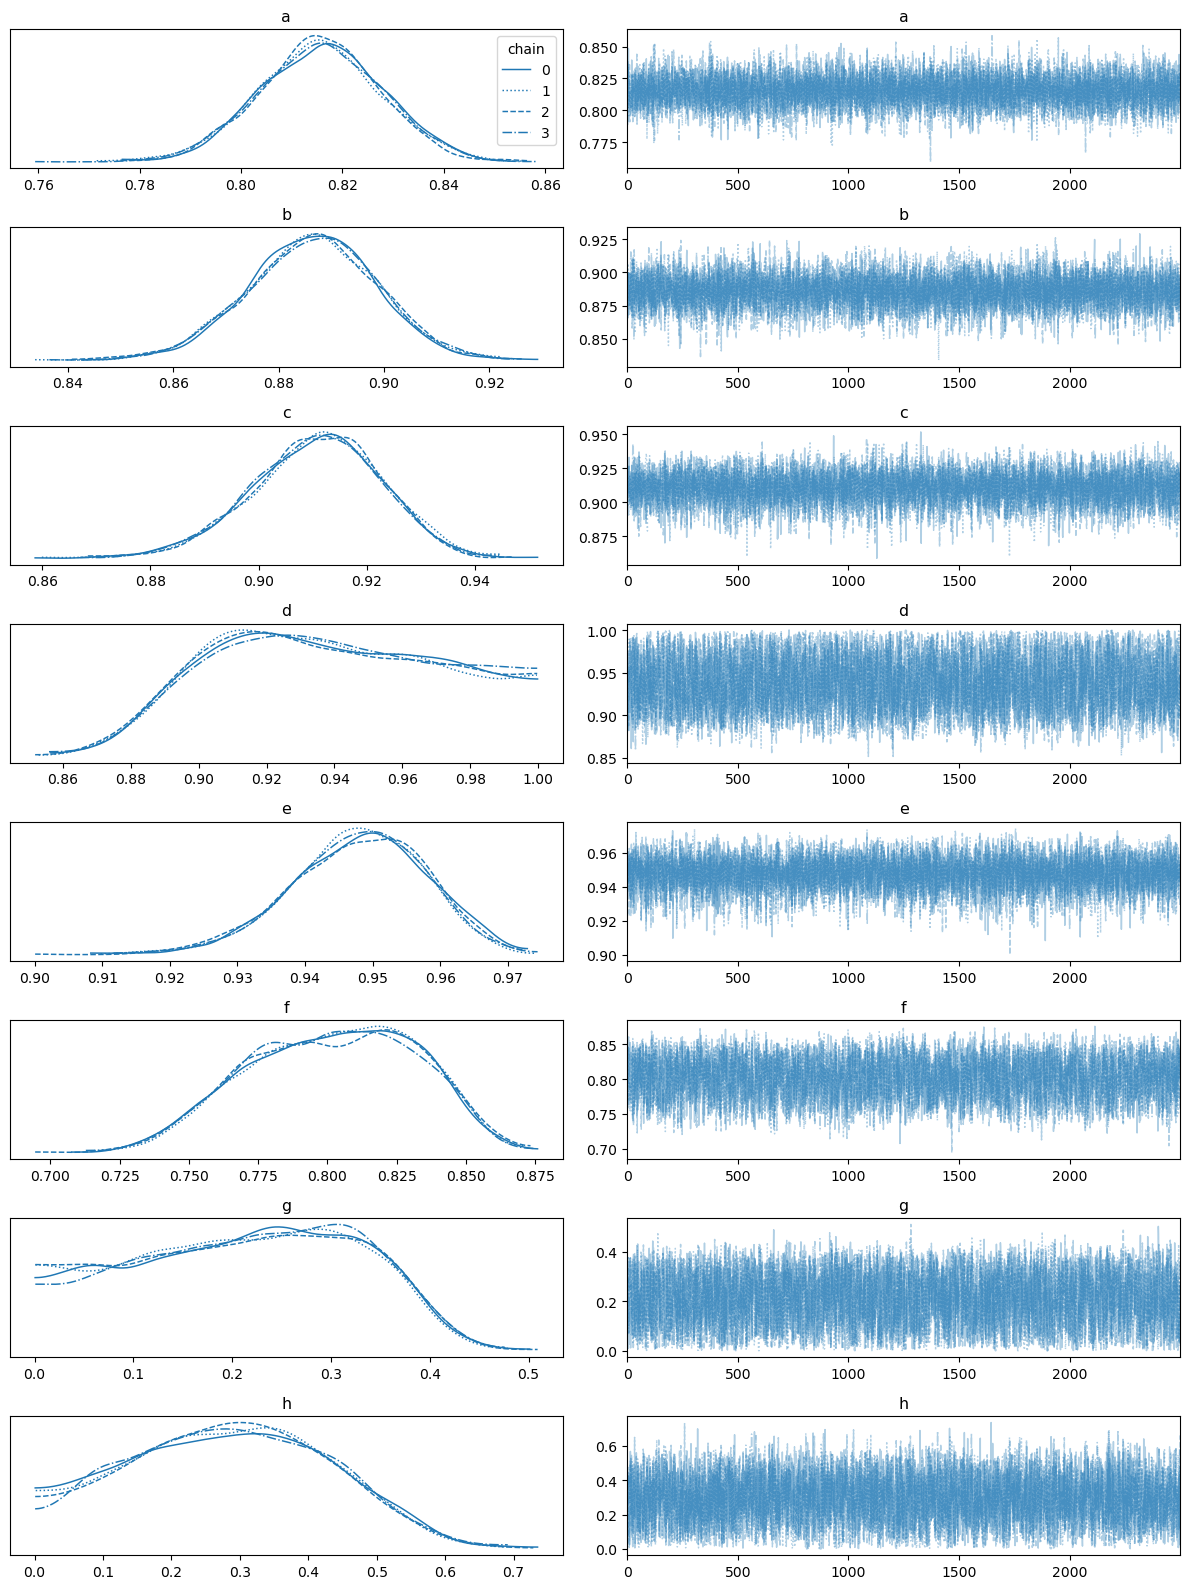

In [6]:
# Traceplots and marginals - visual convergence checks (a-h)
ax_params = az.plot_trace(fit, var_names=[r'^[a-h]'], filter_vars='regex', legend=True)
plt.tight_layout()

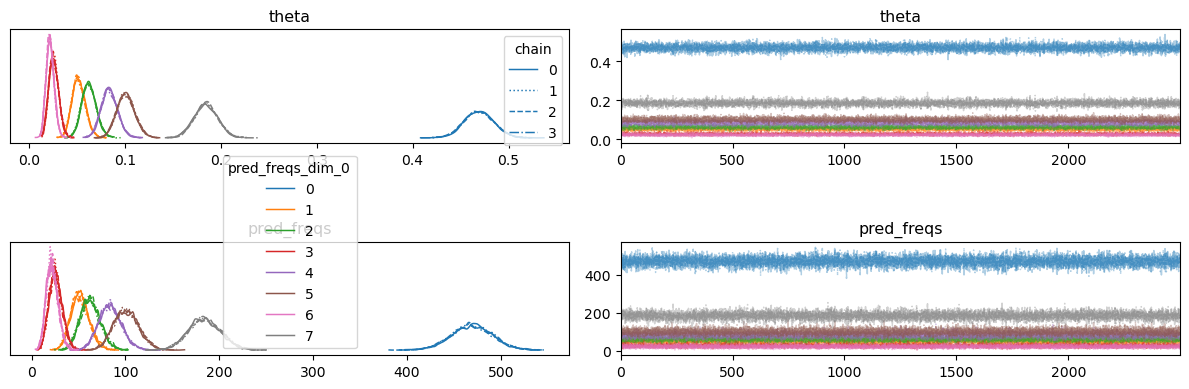

In [7]:
# Traceplots and marginals - visual convergence checks (theta, pred_freqs)
ax_theta = az.plot_trace(fit, var_names=[r'~^[a-h]'], filter_vars='regex', legend=True)
plt.tight_layout()

## **Parameter Recovery**

For the parameters ($a$ to $h$), the model very accurately estimated $c$, $d$, $e$, and $f$. $a$ and $b$ were also relatively accurate estimated (estimated means were just over 1 SD away, but they are within the 94% HDI). 
<br>$g$ was within a SD and the 94% HDI, but that SD was relatively large and the estimated mean was somewhat lower than the actual value. 
<br>$h$ was estimated to be much higher than the actual value. However it did still fall within a SD and the 94% HDI, but mainly because those ranges are very large.